In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
import torch
import numpy as np
import random
from torchsummary import summary
from copy import deepcopy
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F 

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

MNIST_train = MNIST('./', download=True,
transform = transforms.ToTensor(), train=True)
MNIST_test = MNIST('./', download=True,
transform = transforms.ToTensor(), train=False)


--2021-05-31 08:01:45--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-31 08:01:46--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.9MB/s    in 2.8s    

2021-05-31 08:01:49 (11.9 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

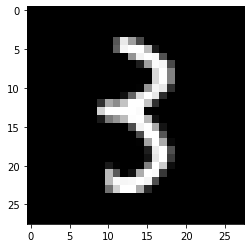

tensor(3)


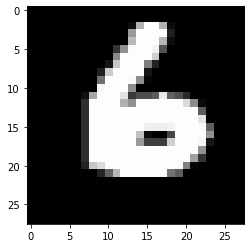

tensor(6)


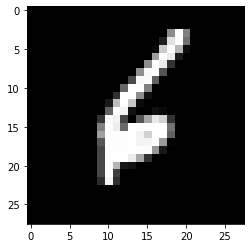

tensor(6)


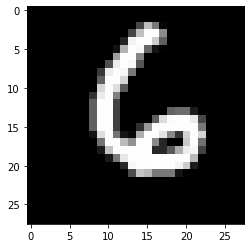

tensor(6)


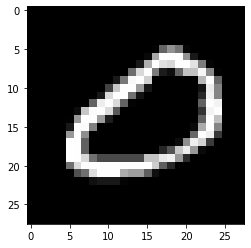

tensor(0)


In [ ]:
import matplotlib.pyplot as plt
def plot_num(x, y, count = 5):
    for i in np.random.permutation(len(x))[:count]:
        plt.imshow(x[i,:,:], cmap = 'gray')
        plt.show()
        print(y[i])
plot_num(X_train, y_train) 

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
class YannLecun(torch.nn.Module):
  def __init__(self,activation = 'leaky relu', pooling = 'max', conv_size = 3, use_batch_norm = False, use_dropout = False):
    super(YannLecun, self).__init__()
    self.conv_size = conv_size
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    if activation == 'relu':
      activation_function = torch.nn.ReLU()
    elif activation == 'tanh':
      activation_function = torch.nn.Tanh()
    elif activation == 'leaky relu':
        activation_function = torch.nn.LeakyReLU()
    else:
      raise NotImplementedError   

    if pooling == 'max':
      pooling_layer = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    elif pooling == 'avg':
      pooling_layer = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    else:
      raise NotImplementedError   
    
    if conv_size == 3:
      self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding= 1)
      self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding= 1)
    elif conv_size == 5:
      self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding= 2)
    else:
      raise NotImplementedError
    
    self.act1 = activation_function
    self.bn1 = torch.nn.BatchNorm2d(num_features = 6)
    self.pool1 = pooling_layer
    self.dp1 = torch.nn.Dropout(p = 0.25) 

    if conv_size == 3:
      self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding= 0)
      self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding= 0)
    elif conv_size == 5:
      self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding= 0)
    else:
      raise NotImplementedError

    self.act2 = activation_function
    self.bn2 = torch.nn.BatchNorm2d(num_features = 16)
    self.pool2 = pooling_layer
    self.dp2 = torch.nn.Dropout(p = 0.25) 

    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act3 = torch.nn.Tanh()
    self.dp3 = torch.nn.Dropout(p = 0.5) 

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.Tanh()
    self.dp4 = torch.nn.Dropout(p = 0.5) 

    self.fc3 = torch.nn.Linear(84,10)
    self.act5 = torch.nn.Softmax()


  def forward(self,x):
    if self.conv_size == 3:
      x = self.conv1_1(x)
      x = self.conv1_2(x)
    elif self.conv_size == 5:
      x = self.conv1(x)

    x = self.act1(x)
    if self.use_batch_norm:
      x = self.bn1(x)
    x = self.pool1(x)
    if self.use_dropout:
      x = self.dp1(x)


    if self.conv_size == 3:
      x = self.conv2_1(x)
      x = self.conv2_2(x)
    elif self.conv_size == 5:
      x = self.conv2(x)
    
    x = self.act2(x)
    if self.use_batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)
    if self.use_dropout:
      x = self.dp2(x)

    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    if self.use_dropout:
      x = self.dp3(x)
    x = self.fc2(x)
    x = self.act4(x)
    if self.use_dropout:
      x = self.dp4(x)
    x = self.fc3(x)
    x = self.act5(x)
    
    x = x.to(device)

    return x

yann_lecun = YannLecun(use_batch_norm = True, use_dropout =True)
yann_lecun = yann_lecun.to(device)
loss = torch.nn.CrossEntropyLoss()
my_optimizer = torch.optim.Adam(yann_lecun.parameters(), lr=4.0e-4)

In [ ]:
def normal_train(X_trains, y_trains, X_tests, y_tests, model = yann_lecun, optimizer = my_optimizer, epochs = 5, batch_sizes = 100):
     
    batch_size = batch_sizes
    test_accuracy_history = []
    test_loss_history = []
    best_val_loss = 1e9
    X_tests = X_tests.to(device)
    y_tests = y_tests.to(device)

    for epoch in range(epochs):
        model.train()
        order = np.random.permutation(len(X_trains))
        for start_index in range(0,len(X_trains), batch_size):
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_trains[batch_indexes].to(device)
            y_batch = y_trains[batch_indexes].to(device)

           # X_batch, y_batch = variable(X_batch), variable(y_batch)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            test_preds = model.forward(X_tests)
            val_loss = loss(test_preds, y_tests)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_parameters = {n: p for n, p in model.named_parameters()}
        test_loss_history.append(val_loss.data.cpu())

        accuracy = (test_preds.argmax(dim = 1) == y_tests).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        print(accuracy)
    return best_parameters 

In [ ]:
best_param1 = normal_train(X_train,y_train, X_test, y_test, epochs = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.9667)
tensor(0.9786)
tensor(0.9802)
tensor(0.9839)
tensor(0.9848)
tensor(0.9861)
tensor(0.9858)
tensor(0.9874)
tensor(0.9878)
tensor(0.9877)
tensor(0.9878)
tensor(0.9876)
tensor(0.9884)
tensor(0.9886)
tensor(0.9883)
tensor(0.9894)
tensor(0.9887)
tensor(0.9887)
tensor(0.9877)
tensor(0.9889)


In [ ]:
lenet2 = YannLecun(use_batch_norm = True, use_dropout =True).to(device)
opt2 = torch.optim.Adam(lenet2.parameters(), lr=4.0e-4)

In [ ]:
best_param2 = normal_train(X_train, y_train, X_test, y_test, model = lenet2, optimizer = opt2, epochs = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.9639)
tensor(0.9773)
tensor(0.9810)
tensor(0.9841)
tensor(0.9841)
tensor(0.9859)
tensor(0.9843)
tensor(0.9871)
tensor(0.9860)
tensor(0.9873)
tensor(0.9881)
tensor(0.9868)
tensor(0.9876)
tensor(0.9875)
tensor(0.9870)
tensor(0.9889)
tensor(0.9888)
tensor(0.9901)
tensor(0.9886)
tensor(0.9898)


In [ ]:
lenet3 = YannLecun(use_batch_norm = True, use_dropout =True).to(device)
opt3 = torch.optim.Adam(lenet3.parameters(), lr=4.0e-4)

In [ ]:
best_param3 = normal_train(X_train,y_train, X_test, y_test, model = lenet3, optimizer = opt3, epochs = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.9644)
tensor(0.9774)
tensor(0.9808)
tensor(0.9828)
tensor(0.9847)
tensor(0.9856)
tensor(0.9856)
tensor(0.9870)
tensor(0.9882)
tensor(0.9876)
tensor(0.9879)
tensor(0.9875)
tensor(0.9873)
tensor(0.9887)
tensor(0.9897)
tensor(0.9895)
tensor(0.9886)
tensor(0.9880)
tensor(0.9888)
tensor(0.9893)


In [ ]:
print(best_param1.keys())

dict_keys(['conv1_1.weight', 'conv1_1.bias', 'conv1_2.weight', 'conv1_2.bias', 'bn1.weight', 'bn1.bias', 'conv2_1.weight', 'conv2_1.bias', 'conv2_2.weight', 'conv2_2.bias', 'bn2.weight', 'bn2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [ ]:
middle_layers = ['conv2_1.weight', 'conv2_1.bias', 'conv2_2.weight','conv2_2.bias']

In [ ]:
print(best_param1[middle_layers[0]].shape)
print(best_param1[middle_layers[1]].shape)
print(best_param1[middle_layers[2]].shape)
print(best_param1[middle_layers[3]].shape)


torch.Size([16, 6, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])


In [ ]:
for layer in middle_layers:
    print(abs(best_param1[layer]-best_param2[layer]).max())


tensor(0.4214, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6614, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3157, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2646, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
for layer in middle_layers:
    print(abs(best_param1[layer]-best_param3[layer]).sum())


tensor(0.5061, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4592, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3693, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2584, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
for layer in middle_layers:
    print(abs(best_param1[layer]).mean())

tensor(0.2659, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3826, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2319, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3577, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
for layer in middle_layers:
    print(abs(best_param2[layer]).sum())

tensor(0.2626, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4040, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2089, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2919, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
for layer in middle_layers:
    print(abs(best_param3[layer]).max())

tensor(0.2815, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3111, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2181, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2318, device='cuda:0', grad_fn=<MaxBackward1>)
